In [1]:
# Импорт библиотек из коробки
import numpy as np
import pandas as pd
import os

import zipfile
with zipfile.ZipFile('/input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/working/')

In [2]:
# Сохраним путь до полученной разархивированной папки
data_root = '/working/plates/'


In [3]:
# Потребуется для формирования папок для датасета Train и Test
import shutil 
from tqdm import tqdm

# Названия папок
train_dir = 'train'
val_dir = 'val'

# Метки и имена классов
class_names = {0: 'cleaned', 
               1: 'dirty'}

# В train и val создаем папки для каждого названия класса датасета
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_names.get(class_name)), exist_ok=True)

# Копируем исходный датасет картинок по одному изображению в Train и каждую 6-ую картинку в Val
# по соответствующему ей названию класса
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_names.get(class_name))
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_names.get(class_name)) # путь до папки в Train
        else:
            dest_dir = os.path.join(val_dir, class_names.get(class_name)) # путь до папки в Val
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name)) # Копируем файл из source_dir в dest_dir 

100%|██████████| 21/21 [00:00<00:00, 4460.44it/s]


In [4]:
import torch
import numpy as np
import random
import torchvision
import matplotlib.pyplot as plt
import time
import copy

seed = 1234
random.seed(seed)
np.random.seed(seed)

torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=False

from torchvision import transforms, models

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2.)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
len(train_dataloader), len(train_dataset)

(4, 30)

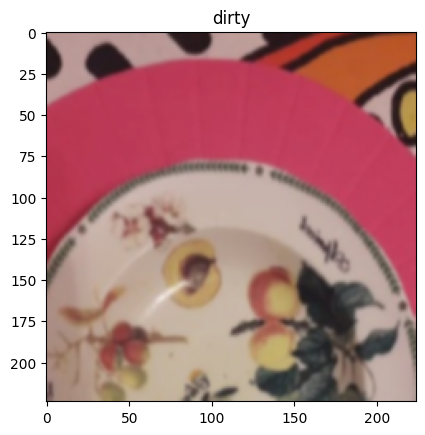

In [6]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# mean = np.array([0.0, 0.0, 0.0])
# std = np.array([0.0, 0.0, 0.0])
plt.title(class_names.get(int(y_batch[0])))
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)
# plt.imshow(X_batch[0].permute(1, 2, 0).numpy())

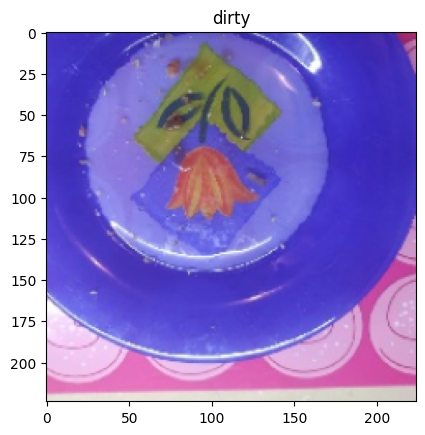

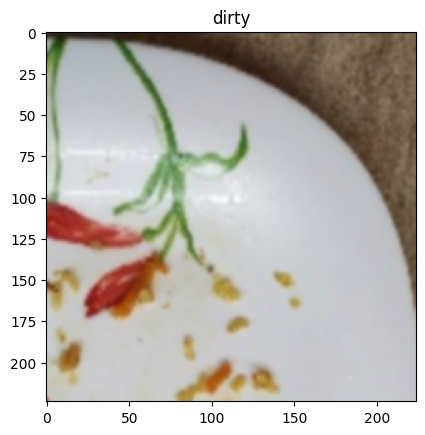

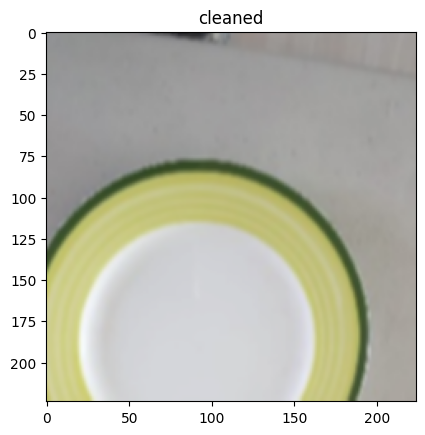

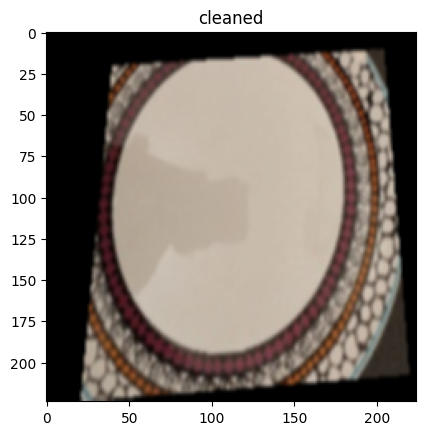

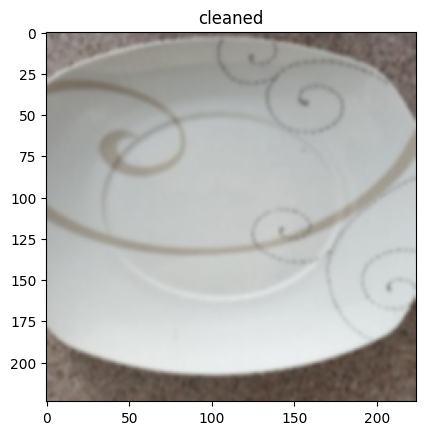

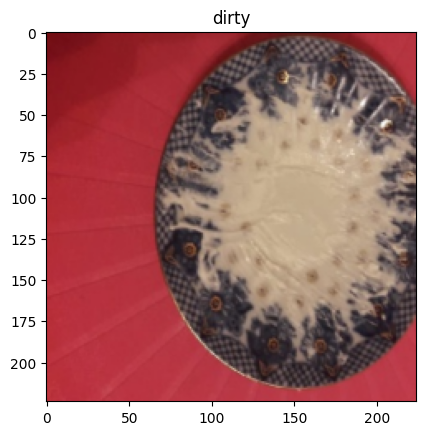

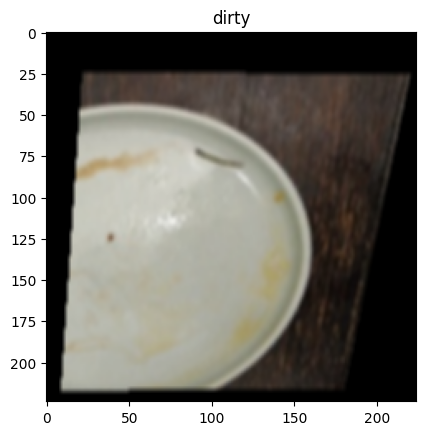

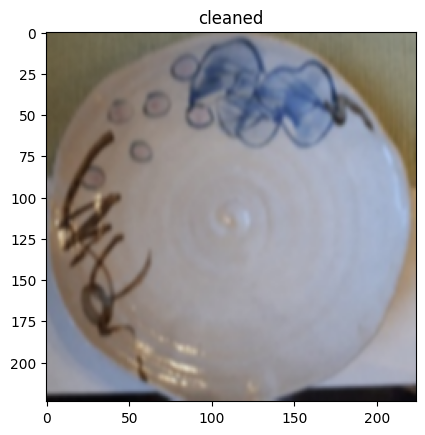

In [7]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names.get(int(y_item)))

In [8]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step(loss_value)

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [9]:
# Загрузка ResNet18 из TorchHub с предобученными весами на датасете ImageNet
model = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [10]:
model.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [11]:
# Отключим градиент для всех параметров ResNet34
for param in model.parameters():
    param.requires_grad = False

model.layer4[1].conv2 = torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# Переопределим последний полносвязный слой  с новыми весами
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1, )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [12]:
train_model(model, loss, optimizer, scheduler, num_epochs=200)

Epoch 0/199:


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

train Loss: 0.9226 Acc: 0.5000



100%|██████████| 2/2 [00:00<00:00,  7.82it/s]

val Loss: 0.9148 Acc: 0.3125
Epoch 1/199:



100%|██████████| 4/4 [00:00<00:00, 12.04it/s]

train Loss: 0.7356 Acc: 0.6042



100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

val Loss: 0.6321 Acc: 0.5625
Epoch 2/199:



100%|██████████| 4/4 [00:00<00:00, 11.92it/s]

train Loss: 0.6862 Acc: 0.8021



100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

val Loss: 0.3453 Acc: 0.8750
Epoch 3/199:



100%|██████████| 4/4 [00:00<00:00, 11.54it/s]

train Loss: 0.5717 Acc: 0.6875



100%|██████████| 2/2 [00:00<00:00,  8.89it/s]

val Loss: 0.2871 Acc: 0.8750
Epoch 4/199:



100%|██████████| 4/4 [00:00<00:00, 11.69it/s]

train Loss: 0.2303 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

val Loss: 0.2879 Acc: 0.8750
Epoch 5/199:



100%|██████████| 4/4 [00:00<00:00, 11.84it/s]

train Loss: 0.4682 Acc: 0.6875



100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

val Loss: 0.2786 Acc: 0.8750
Epoch 6/199:



100%|██████████| 4/4 [00:00<00:00, 11.94it/s]

train Loss: 0.2908 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

val Loss: 0.3374 Acc: 0.8750
Epoch 7/199:



100%|██████████| 4/4 [00:00<00:00, 11.48it/s]

train Loss: 0.3952 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

val Loss: 0.3174 Acc: 0.8750
Epoch 8/199:



100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

train Loss: 0.1777 Acc: 0.9583



100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

val Loss: 0.3392 Acc: 0.8750
Epoch 9/199:



100%|██████████| 4/4 [00:00<00:00, 12.02it/s]

train Loss: 0.2752 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

val Loss: 0.3408 Acc: 0.8750
Epoch 10/199:



100%|██████████| 4/4 [00:00<00:00, 12.03it/s]

train Loss: 0.3760 Acc: 0.7917



100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

val Loss: 0.2625 Acc: 0.8750
Epoch 11/199:



100%|██████████| 4/4 [00:00<00:00, 12.07it/s]

train Loss: 0.3383 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  9.24it/s]

val Loss: 0.2613 Acc: 0.8750
Epoch 12/199:



100%|██████████| 4/4 [00:00<00:00,  9.74it/s]

train Loss: 0.2794 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

val Loss: 0.2473 Acc: 0.8750
Epoch 13/199:



100%|██████████| 4/4 [00:00<00:00, 11.31it/s]

train Loss: 0.3201 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

val Loss: 0.2485 Acc: 0.8750
Epoch 14/199:



100%|██████████| 4/4 [00:00<00:00, 11.46it/s]

train Loss: 0.4058 Acc: 0.7292



100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

val Loss: 0.2469 Acc: 0.8750
Epoch 15/199:



100%|██████████| 4/4 [00:00<00:00, 12.05it/s]

train Loss: 0.3571 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  8.87it/s]

val Loss: 0.2808 Acc: 0.8750
Epoch 16/199:



100%|██████████| 4/4 [00:00<00:00, 11.82it/s]

train Loss: 0.3565 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

val Loss: 0.3233 Acc: 0.8750
Epoch 17/199:



100%|██████████| 4/4 [00:00<00:00, 10.96it/s]

train Loss: 0.3907 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  9.45it/s]

val Loss: 0.3310 Acc: 0.8750
Epoch 18/199:



100%|██████████| 4/4 [00:00<00:00, 11.93it/s]

train Loss: 0.2730 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

val Loss: 0.2970 Acc: 0.8750
Epoch 19/199:



100%|██████████| 4/4 [00:00<00:00, 11.85it/s]

train Loss: 0.3737 Acc: 0.8021



100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

val Loss: 0.2900 Acc: 0.8750
Epoch 20/199:



100%|██████████| 4/4 [00:00<00:00, 11.65it/s]

train Loss: 0.5118 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

val Loss: 0.2928 Acc: 0.8750
Epoch 21/199:



100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

train Loss: 0.3011 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

val Loss: 0.2733 Acc: 0.8750
Epoch 22/199:



100%|██████████| 4/4 [00:00<00:00, 11.41it/s]

train Loss: 0.3471 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

val Loss: 0.2632 Acc: 0.8750
Epoch 23/199:



100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

train Loss: 0.4900 Acc: 0.7396



100%|██████████| 2/2 [00:00<00:00,  8.09it/s]

val Loss: 0.2777 Acc: 0.8750
Epoch 24/199:



100%|██████████| 4/4 [00:00<00:00, 11.26it/s]

train Loss: 0.3187 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

val Loss: 0.2586 Acc: 0.8750
Epoch 25/199:



100%|██████████| 4/4 [00:00<00:00, 12.28it/s]

train Loss: 0.3070 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

val Loss: 0.2820 Acc: 0.8750
Epoch 26/199:



100%|██████████| 4/4 [00:00<00:00, 12.19it/s]

train Loss: 0.2397 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

val Loss: 0.2675 Acc: 0.8750
Epoch 27/199:



100%|██████████| 4/4 [00:00<00:00, 11.90it/s]

train Loss: 0.4034 Acc: 0.8542



100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

val Loss: 0.2392 Acc: 0.8750
Epoch 28/199:



100%|██████████| 4/4 [00:00<00:00, 12.14it/s]

train Loss: 0.3583 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

val Loss: 0.2435 Acc: 0.8750
Epoch 29/199:



100%|██████████| 4/4 [00:00<00:00, 10.27it/s]

train Loss: 0.2697 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

val Loss: 0.2349 Acc: 0.8750
Epoch 30/199:



100%|██████████| 4/4 [00:00<00:00, 11.18it/s]

train Loss: 0.4491 Acc: 0.7292



100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

val Loss: 0.2428 Acc: 0.8750
Epoch 31/199:



100%|██████████| 4/4 [00:00<00:00, 10.64it/s]

train Loss: 0.1936 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  9.00it/s]

val Loss: 0.2519 Acc: 0.8750
Epoch 32/199:



100%|██████████| 4/4 [00:00<00:00, 11.47it/s]

train Loss: 0.4569 Acc: 0.7917



100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

val Loss: 0.2724 Acc: 0.8750
Epoch 33/199:



100%|██████████| 4/4 [00:00<00:00, 11.96it/s]

train Loss: 0.2819 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

val Loss: 0.2561 Acc: 0.8750
Epoch 34/199:



100%|██████████| 4/4 [00:00<00:00, 11.78it/s]

train Loss: 0.2394 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

val Loss: 0.2631 Acc: 0.8750
Epoch 35/199:



100%|██████████| 4/4 [00:00<00:00, 11.87it/s]

train Loss: 0.3367 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

val Loss: 0.2683 Acc: 0.8750
Epoch 36/199:



100%|██████████| 4/4 [00:00<00:00, 11.74it/s]

train Loss: 0.2341 Acc: 0.8854



100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

val Loss: 0.2566 Acc: 0.8750
Epoch 37/199:



100%|██████████| 4/4 [00:00<00:00, 12.02it/s]

train Loss: 0.3218 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

val Loss: 0.2671 Acc: 0.8750
Epoch 38/199:



100%|██████████| 4/4 [00:00<00:00, 11.70it/s]

train Loss: 0.3589 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

val Loss: 0.2728 Acc: 0.8750
Epoch 39/199:



100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

train Loss: 0.4176 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  9.01it/s]

val Loss: 0.2463 Acc: 0.8750
Epoch 40/199:



100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

train Loss: 0.4628 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

val Loss: 0.2562 Acc: 0.8750
Epoch 41/199:



100%|██████████| 4/4 [00:00<00:00, 11.35it/s]

train Loss: 0.2893 Acc: 0.8542



100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

val Loss: 0.2489 Acc: 0.8750
Epoch 42/199:



100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

train Loss: 0.2998 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  9.04it/s]

val Loss: 0.2668 Acc: 0.8750
Epoch 43/199:



100%|██████████| 4/4 [00:00<00:00, 11.75it/s]

train Loss: 0.4654 Acc: 0.6979



100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

val Loss: 0.2807 Acc: 0.8750
Epoch 44/199:



100%|██████████| 4/4 [00:00<00:00, 11.82it/s]

train Loss: 0.3695 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

val Loss: 0.2411 Acc: 0.8750
Epoch 45/199:



100%|██████████| 4/4 [00:00<00:00, 11.45it/s]

train Loss: 0.4197 Acc: 0.8125



100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

val Loss: 0.2477 Acc: 0.8750
Epoch 46/199:



100%|██████████| 4/4 [00:00<00:00, 10.82it/s]

train Loss: 0.7174 Acc: 0.6562



100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

val Loss: 0.2506 Acc: 0.8750
Epoch 47/199:



100%|██████████| 4/4 [00:00<00:00, 11.19it/s]

train Loss: 0.3807 Acc: 0.8854



100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

val Loss: 0.2770 Acc: 0.8750
Epoch 48/199:



100%|██████████| 4/4 [00:00<00:00, 11.85it/s]

train Loss: 0.3179 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

val Loss: 0.2884 Acc: 0.8750
Epoch 49/199:



100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

train Loss: 0.4517 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

val Loss: 0.2694 Acc: 0.8750
Epoch 50/199:



100%|██████████| 4/4 [00:00<00:00,  9.20it/s]

train Loss: 0.3095 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

val Loss: 0.2683 Acc: 0.8750
Epoch 51/199:



100%|██████████| 4/4 [00:00<00:00, 10.27it/s]

train Loss: 0.1781 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

val Loss: 0.2967 Acc: 0.8750
Epoch 52/199:



100%|██████████| 4/4 [00:00<00:00, 12.13it/s]

train Loss: 0.2693 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

val Loss: 0.3056 Acc: 0.8750
Epoch 53/199:



100%|██████████| 4/4 [00:00<00:00, 10.92it/s]

train Loss: 0.3621 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  9.34it/s]

val Loss: 0.2583 Acc: 0.8750
Epoch 54/199:



100%|██████████| 4/4 [00:00<00:00, 12.15it/s]

train Loss: 0.3701 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

val Loss: 0.2683 Acc: 0.8750
Epoch 55/199:



100%|██████████| 4/4 [00:00<00:00, 11.68it/s]

train Loss: 0.2551 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

val Loss: 0.2631 Acc: 0.8750
Epoch 56/199:



100%|██████████| 4/4 [00:00<00:00, 11.77it/s]

train Loss: 0.2825 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.85it/s]

val Loss: 0.2501 Acc: 0.8750
Epoch 57/199:



100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

train Loss: 0.3889 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.72it/s]

val Loss: 0.2361 Acc: 0.8750
Epoch 58/199:



100%|██████████| 4/4 [00:00<00:00,  9.68it/s]

train Loss: 0.3714 Acc: 0.8542



100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

val Loss: 0.2425 Acc: 0.8750
Epoch 59/199:



100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

train Loss: 0.2203 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

val Loss: 0.2349 Acc: 0.8750
Epoch 60/199:



100%|██████████| 4/4 [00:00<00:00,  9.33it/s]

train Loss: 0.3095 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

val Loss: 0.2414 Acc: 0.8750
Epoch 61/199:



100%|██████████| 4/4 [00:00<00:00, 11.94it/s]

train Loss: 0.2337 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

val Loss: 0.2256 Acc: 0.8750
Epoch 62/199:



100%|██████████| 4/4 [00:00<00:00,  9.79it/s]

train Loss: 0.3190 Acc: 0.8542



100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

val Loss: 0.2487 Acc: 0.8750
Epoch 63/199:



100%|██████████| 4/4 [00:00<00:00, 11.31it/s]

train Loss: 0.2701 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

val Loss: 0.2750 Acc: 0.8750
Epoch 64/199:



100%|██████████| 4/4 [00:00<00:00, 12.05it/s]

train Loss: 0.2064 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

val Loss: 0.2694 Acc: 0.8750
Epoch 65/199:



100%|██████████| 4/4 [00:00<00:00, 11.87it/s]

train Loss: 0.3480 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

val Loss: 0.2590 Acc: 0.8750
Epoch 66/199:



100%|██████████| 4/4 [00:00<00:00, 11.32it/s]

train Loss: 0.3295 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

val Loss: 0.2578 Acc: 0.8750
Epoch 67/199:



100%|██████████| 4/4 [00:00<00:00, 11.94it/s]

train Loss: 0.3155 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

val Loss: 0.2584 Acc: 0.8750
Epoch 68/199:



100%|██████████| 4/4 [00:00<00:00, 11.89it/s]

train Loss: 0.2461 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

val Loss: 0.2529 Acc: 0.8750
Epoch 69/199:



100%|██████████| 4/4 [00:00<00:00, 11.31it/s]

train Loss: 0.2823 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

val Loss: 0.2587 Acc: 0.8750
Epoch 70/199:



100%|██████████| 4/4 [00:00<00:00, 12.01it/s]

train Loss: 0.3469 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

val Loss: 0.2850 Acc: 0.8750
Epoch 71/199:



100%|██████████| 4/4 [00:00<00:00, 11.39it/s]

train Loss: 0.2504 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

val Loss: 0.2742 Acc: 0.8750
Epoch 72/199:



100%|██████████| 4/4 [00:00<00:00, 12.05it/s]

train Loss: 0.3572 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

val Loss: 0.2683 Acc: 0.8750
Epoch 73/199:



100%|██████████| 4/4 [00:00<00:00, 11.96it/s]

train Loss: 0.2436 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

val Loss: 0.2536 Acc: 0.8750
Epoch 74/199:



100%|██████████| 4/4 [00:00<00:00, 11.28it/s]

train Loss: 0.2909 Acc: 0.9583



100%|██████████| 2/2 [00:00<00:00,  9.22it/s]

val Loss: 0.2504 Acc: 0.8750
Epoch 75/199:



100%|██████████| 4/4 [00:00<00:00, 11.87it/s]

train Loss: 0.4810 Acc: 0.7604



100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

val Loss: 0.2534 Acc: 0.8750
Epoch 76/199:



100%|██████████| 4/4 [00:00<00:00, 11.87it/s]

train Loss: 0.3440 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  8.87it/s]

val Loss: 0.2437 Acc: 0.8750
Epoch 77/199:



100%|██████████| 4/4 [00:00<00:00, 11.70it/s]

train Loss: 0.2431 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

val Loss: 0.2515 Acc: 0.8750
Epoch 78/199:



100%|██████████| 4/4 [00:00<00:00, 11.07it/s]

train Loss: 0.4175 Acc: 0.8021



100%|██████████| 2/2 [00:00<00:00,  9.29it/s]

val Loss: 0.2727 Acc: 0.8750
Epoch 79/199:



100%|██████████| 4/4 [00:00<00:00, 10.49it/s]

train Loss: 0.1886 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

val Loss: 0.2371 Acc: 0.8750
Epoch 80/199:



100%|██████████| 4/4 [00:00<00:00, 11.94it/s]

train Loss: 0.2203 Acc: 0.9583



100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

val Loss: 0.2414 Acc: 0.8750
Epoch 81/199:



100%|██████████| 4/4 [00:00<00:00, 11.42it/s]

train Loss: 0.4396 Acc: 0.7188



100%|██████████| 2/2 [00:00<00:00,  7.77it/s]

val Loss: 0.2393 Acc: 0.8750
Epoch 82/199:



100%|██████████| 4/4 [00:00<00:00, 11.95it/s]

train Loss: 0.3508 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

val Loss: 0.2520 Acc: 0.8750
Epoch 83/199:



100%|██████████| 4/4 [00:00<00:00, 11.34it/s]

train Loss: 0.2498 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

val Loss: 0.2575 Acc: 0.8750
Epoch 84/199:



100%|██████████| 4/4 [00:00<00:00, 11.45it/s]

train Loss: 0.3805 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

val Loss: 0.2778 Acc: 0.8750
Epoch 85/199:



100%|██████████| 4/4 [00:00<00:00, 11.30it/s]

train Loss: 0.4212 Acc: 0.7604



100%|██████████| 2/2 [00:00<00:00,  9.29it/s]

val Loss: 0.2883 Acc: 0.8750
Epoch 86/199:



100%|██████████| 4/4 [00:00<00:00, 12.19it/s]

train Loss: 0.2902 Acc: 0.8542



100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

val Loss: 0.3210 Acc: 0.8750
Epoch 87/199:



100%|██████████| 4/4 [00:00<00:00, 11.56it/s]

train Loss: 0.3246 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

val Loss: 0.2939 Acc: 0.8750
Epoch 88/199:



100%|██████████| 4/4 [00:00<00:00, 10.81it/s]

train Loss: 0.5502 Acc: 0.7708



100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

val Loss: 0.2902 Acc: 0.8750
Epoch 89/199:



100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

train Loss: 0.4240 Acc: 0.7917



100%|██████████| 2/2 [00:00<00:00,  9.01it/s]

val Loss: 0.3038 Acc: 0.8750
Epoch 90/199:



100%|██████████| 4/4 [00:00<00:00, 11.62it/s]

train Loss: 0.2558 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

val Loss: 0.2765 Acc: 0.8750
Epoch 91/199:



100%|██████████| 4/4 [00:00<00:00, 11.77it/s]

train Loss: 0.1615 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

val Loss: 0.2636 Acc: 0.8750
Epoch 92/199:



100%|██████████| 4/4 [00:00<00:00, 11.24it/s]

train Loss: 0.2387 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  9.01it/s]

val Loss: 0.2582 Acc: 0.8750
Epoch 93/199:



100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

train Loss: 0.3407 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

val Loss: 0.2510 Acc: 0.8750
Epoch 94/199:



100%|██████████| 4/4 [00:00<00:00, 11.43it/s]

train Loss: 0.2970 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

val Loss: 0.2669 Acc: 0.8750
Epoch 95/199:



100%|██████████| 4/4 [00:00<00:00, 11.78it/s]

train Loss: 0.2498 Acc: 0.9583



100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

val Loss: 0.2413 Acc: 0.8750
Epoch 96/199:



100%|██████████| 4/4 [00:00<00:00, 11.56it/s]

train Loss: 0.2972 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.23it/s]

val Loss: 0.2373 Acc: 0.8750
Epoch 97/199:



100%|██████████| 4/4 [00:00<00:00, 11.41it/s]

train Loss: 0.3268 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

val Loss: 0.2415 Acc: 0.8750
Epoch 98/199:



100%|██████████| 4/4 [00:00<00:00, 11.85it/s]

train Loss: 0.3689 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

val Loss: 0.2400 Acc: 0.8750
Epoch 99/199:



100%|██████████| 4/4 [00:00<00:00, 10.67it/s]

train Loss: 0.3515 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

val Loss: 0.2411 Acc: 0.8750
Epoch 100/199:



100%|██████████| 4/4 [00:00<00:00, 11.39it/s]

train Loss: 0.2702 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

val Loss: 0.2556 Acc: 0.8750
Epoch 101/199:



100%|██████████| 4/4 [00:00<00:00, 11.57it/s]

train Loss: 0.3758 Acc: 0.8021



100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

val Loss: 0.2697 Acc: 0.8750
Epoch 102/199:



100%|██████████| 4/4 [00:00<00:00, 11.32it/s]

train Loss: 0.3569 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

val Loss: 0.2714 Acc: 0.8750
Epoch 103/199:



100%|██████████| 4/4 [00:00<00:00,  9.04it/s]

train Loss: 0.2852 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  7.72it/s]

val Loss: 0.2649 Acc: 0.8750
Epoch 104/199:



100%|██████████| 4/4 [00:00<00:00,  9.47it/s]

train Loss: 0.3770 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

val Loss: 0.2557 Acc: 0.8750
Epoch 105/199:



100%|██████████| 4/4 [00:00<00:00, 11.05it/s]

train Loss: 0.2675 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.73it/s]

val Loss: 0.2542 Acc: 0.8750
Epoch 106/199:



100%|██████████| 4/4 [00:00<00:00, 12.10it/s]

train Loss: 0.1599 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

val Loss: 0.2320 Acc: 0.8750
Epoch 107/199:



100%|██████████| 4/4 [00:00<00:00, 11.98it/s]

train Loss: 0.2806 Acc: 0.8854



100%|██████████| 2/2 [00:00<00:00,  9.14it/s]

val Loss: 0.2355 Acc: 0.8750
Epoch 108/199:



100%|██████████| 4/4 [00:00<00:00, 11.97it/s]

train Loss: 0.2652 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  9.14it/s]

val Loss: 0.2357 Acc: 0.8750
Epoch 109/199:



100%|██████████| 4/4 [00:00<00:00, 11.54it/s]

train Loss: 0.2073 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

val Loss: 0.2293 Acc: 0.8750
Epoch 110/199:



100%|██████████| 4/4 [00:00<00:00, 11.54it/s]

train Loss: 0.2805 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

val Loss: 0.2337 Acc: 0.8750
Epoch 111/199:



100%|██████████| 4/4 [00:00<00:00, 11.98it/s]

train Loss: 0.3580 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

val Loss: 0.2475 Acc: 0.8750
Epoch 112/199:



100%|██████████| 4/4 [00:00<00:00, 11.46it/s]

train Loss: 0.4148 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  8.87it/s]

val Loss: 0.2400 Acc: 0.8750
Epoch 113/199:



100%|██████████| 4/4 [00:00<00:00,  9.84it/s]

train Loss: 0.3908 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  7.69it/s]

val Loss: 0.2052 Acc: 0.8750
Epoch 114/199:



100%|██████████| 4/4 [00:00<00:00, 11.13it/s]

train Loss: 0.3890 Acc: 0.7708



100%|██████████| 2/2 [00:00<00:00,  7.93it/s]

val Loss: 0.2143 Acc: 0.8750
Epoch 115/199:



100%|██████████| 4/4 [00:00<00:00, 11.66it/s]

train Loss: 0.3170 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

val Loss: 0.2534 Acc: 0.8750
Epoch 116/199:



100%|██████████| 4/4 [00:00<00:00, 11.25it/s]

train Loss: 0.3104 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  7.75it/s]

val Loss: 0.2729 Acc: 0.8750
Epoch 117/199:



100%|██████████| 4/4 [00:00<00:00, 10.53it/s]

train Loss: 0.3843 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

val Loss: 0.2649 Acc: 0.8750
Epoch 118/199:



100%|██████████| 4/4 [00:00<00:00, 11.04it/s]

train Loss: 0.2994 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.38it/s]

val Loss: 0.2485 Acc: 0.8750
Epoch 119/199:



100%|██████████| 4/4 [00:00<00:00, 11.11it/s]

train Loss: 0.2855 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

val Loss: 0.2530 Acc: 0.8750
Epoch 120/199:



100%|██████████| 4/4 [00:00<00:00, 11.57it/s]

train Loss: 0.3728 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

val Loss: 0.2601 Acc: 0.8750
Epoch 121/199:



100%|██████████| 4/4 [00:00<00:00, 11.69it/s]

train Loss: 0.3743 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.15it/s]

val Loss: 0.2648 Acc: 0.8750
Epoch 122/199:



100%|██████████| 4/4 [00:00<00:00, 11.60it/s]

train Loss: 0.2875 Acc: 0.8854



100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

val Loss: 0.2837 Acc: 0.8750
Epoch 123/199:



100%|██████████| 4/4 [00:00<00:00, 11.45it/s]

train Loss: 0.3947 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

val Loss: 0.2592 Acc: 0.8750
Epoch 124/199:



100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

train Loss: 0.1751 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.98it/s]

val Loss: 0.2600 Acc: 0.8750
Epoch 125/199:



100%|██████████| 4/4 [00:00<00:00, 11.86it/s]

train Loss: 0.2125 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

val Loss: 0.2575 Acc: 0.8750
Epoch 126/199:



100%|██████████| 4/4 [00:00<00:00, 11.13it/s]

train Loss: 0.2008 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  9.24it/s]

val Loss: 0.2277 Acc: 0.8750
Epoch 127/199:



100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

train Loss: 0.2353 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

val Loss: 0.2128 Acc: 0.8750
Epoch 128/199:



100%|██████████| 4/4 [00:00<00:00, 11.95it/s]

train Loss: 0.4850 Acc: 0.7500



100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

val Loss: 0.2237 Acc: 0.8750
Epoch 129/199:



100%|██████████| 4/4 [00:00<00:00, 12.03it/s]

train Loss: 0.2143 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

val Loss: 0.2363 Acc: 0.8750
Epoch 130/199:



100%|██████████| 4/4 [00:00<00:00, 10.41it/s]

train Loss: 0.3718 Acc: 0.7604



100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

val Loss: 0.2378 Acc: 0.8750
Epoch 131/199:



100%|██████████| 4/4 [00:00<00:00, 11.55it/s]

train Loss: 0.1685 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

val Loss: 0.2644 Acc: 0.8750
Epoch 132/199:



100%|██████████| 4/4 [00:00<00:00, 11.59it/s]

train Loss: 0.1938 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

val Loss: 0.2699 Acc: 0.8750
Epoch 133/199:



100%|██████████| 4/4 [00:00<00:00, 10.63it/s]

train Loss: 0.2714 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.85it/s]

val Loss: 0.2497 Acc: 0.8750
Epoch 134/199:



100%|██████████| 4/4 [00:00<00:00, 11.27it/s]

train Loss: 0.2475 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

val Loss: 0.2526 Acc: 0.8750
Epoch 135/199:



100%|██████████| 4/4 [00:00<00:00, 11.48it/s]

train Loss: 0.3033 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

val Loss: 0.2537 Acc: 0.8750
Epoch 136/199:



100%|██████████| 4/4 [00:00<00:00, 11.38it/s]

train Loss: 0.1697 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

val Loss: 0.2518 Acc: 0.8750
Epoch 137/199:



100%|██████████| 4/4 [00:00<00:00, 10.78it/s]

train Loss: 0.2799 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

val Loss: 0.2579 Acc: 0.8750
Epoch 138/199:



100%|██████████| 4/4 [00:00<00:00, 11.85it/s]

train Loss: 0.2566 Acc: 0.8854



100%|██████████| 2/2 [00:00<00:00,  7.87it/s]

val Loss: 0.2316 Acc: 0.8750
Epoch 139/199:



100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

train Loss: 0.2739 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

val Loss: 0.2254 Acc: 0.8750
Epoch 140/199:



100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

train Loss: 0.3984 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  7.18it/s]

val Loss: 0.2354 Acc: 0.8750
Epoch 141/199:



100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

train Loss: 0.2625 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

val Loss: 0.2512 Acc: 0.8750
Epoch 142/199:



100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

train Loss: 0.2638 Acc: 0.9167



100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

val Loss: 0.2498 Acc: 0.8750
Epoch 143/199:



100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

train Loss: 0.2193 Acc: 0.9583



100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

val Loss: 0.2202 Acc: 0.8750
Epoch 144/199:



100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

train Loss: 0.2925 Acc: 0.8542



100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

val Loss: 0.2291 Acc: 0.8750
Epoch 145/199:



100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

train Loss: 0.4114 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

val Loss: 0.2487 Acc: 0.8750
Epoch 146/199:



100%|██████████| 4/4 [00:00<00:00,  9.77it/s]

train Loss: 0.3691 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

val Loss: 0.2499 Acc: 0.8750
Epoch 147/199:



100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

train Loss: 0.3719 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

val Loss: 0.2383 Acc: 0.8750
Epoch 148/199:



100%|██████████| 4/4 [00:00<00:00, 10.27it/s]

train Loss: 0.2172 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.80it/s]

val Loss: 0.2416 Acc: 0.8750
Epoch 149/199:



100%|██████████| 4/4 [00:00<00:00, 12.02it/s]

train Loss: 0.1852 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

val Loss: 0.2510 Acc: 0.8750
Epoch 150/199:



100%|██████████| 4/4 [00:00<00:00, 11.96it/s]

train Loss: 0.2644 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

val Loss: 0.2379 Acc: 0.8750
Epoch 151/199:



100%|██████████| 4/4 [00:00<00:00, 12.16it/s]

train Loss: 0.3516 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

val Loss: 0.2292 Acc: 0.8750
Epoch 152/199:



100%|██████████| 4/4 [00:00<00:00, 11.49it/s]

train Loss: 0.3830 Acc: 0.8229



100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

val Loss: 0.2215 Acc: 0.8750
Epoch 153/199:



100%|██████████| 4/4 [00:00<00:00, 10.30it/s]

train Loss: 0.2818 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

val Loss: 0.2365 Acc: 0.8750
Epoch 154/199:



100%|██████████| 4/4 [00:00<00:00,  9.56it/s]

train Loss: 0.2362 Acc: 0.8854



100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

val Loss: 0.2437 Acc: 0.8750
Epoch 155/199:



100%|██████████| 4/4 [00:00<00:00,  9.79it/s]

train Loss: 0.2445 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

val Loss: 0.2506 Acc: 0.8750
Epoch 156/199:



100%|██████████| 4/4 [00:00<00:00, 11.49it/s]

train Loss: 0.1776 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

val Loss: 0.2401 Acc: 0.8750
Epoch 157/199:



100%|██████████| 4/4 [00:00<00:00, 11.64it/s]

train Loss: 0.4143 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

val Loss: 0.2261 Acc: 0.8750
Epoch 158/199:



100%|██████████| 4/4 [00:00<00:00, 11.47it/s]

train Loss: 0.2696 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

val Loss: 0.2465 Acc: 0.8750
Epoch 159/199:



100%|██████████| 4/4 [00:00<00:00, 11.83it/s]

train Loss: 0.2253 Acc: 0.9167



100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

val Loss: 0.2474 Acc: 0.8750
Epoch 160/199:



100%|██████████| 4/4 [00:00<00:00, 11.18it/s]

train Loss: 0.3031 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

val Loss: 0.2440 Acc: 0.8750
Epoch 161/199:



100%|██████████| 4/4 [00:00<00:00, 11.36it/s]

train Loss: 0.2409 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

val Loss: 0.2394 Acc: 0.8750
Epoch 162/199:



100%|██████████| 4/4 [00:00<00:00, 11.10it/s]

train Loss: 0.1469 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

val Loss: 0.2524 Acc: 0.8750
Epoch 163/199:



100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

train Loss: 0.4115 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

val Loss: 0.2437 Acc: 0.8750
Epoch 164/199:



100%|██████████| 4/4 [00:00<00:00, 11.57it/s]

train Loss: 0.2723 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.83it/s]

val Loss: 0.2542 Acc: 0.8750
Epoch 165/199:



100%|██████████| 4/4 [00:00<00:00, 11.80it/s]

train Loss: 0.2699 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

val Loss: 0.2571 Acc: 0.8750
Epoch 166/199:



100%|██████████| 4/4 [00:00<00:00, 11.63it/s]

train Loss: 0.2594 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

val Loss: 0.2666 Acc: 0.8750
Epoch 167/199:



100%|██████████| 4/4 [00:00<00:00, 11.43it/s]

train Loss: 0.2682 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

val Loss: 0.2724 Acc: 0.8750
Epoch 168/199:



100%|██████████| 4/4 [00:00<00:00, 11.74it/s]

train Loss: 0.2470 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.38it/s]

val Loss: 0.2482 Acc: 0.8750
Epoch 169/199:



100%|██████████| 4/4 [00:00<00:00, 11.22it/s]

train Loss: 0.3592 Acc: 0.7292



100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

val Loss: 0.2691 Acc: 0.8750
Epoch 170/199:



100%|██████████| 4/4 [00:00<00:00, 10.91it/s]

train Loss: 0.3192 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

val Loss: 0.2549 Acc: 0.8750
Epoch 171/199:



100%|██████████| 4/4 [00:00<00:00, 11.10it/s]

train Loss: 0.3366 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

val Loss: 0.2591 Acc: 0.8750
Epoch 172/199:



100%|██████████| 4/4 [00:00<00:00, 11.51it/s]

train Loss: 0.3260 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  9.18it/s]

val Loss: 0.2694 Acc: 0.8750
Epoch 173/199:



100%|██████████| 4/4 [00:00<00:00, 11.77it/s]

train Loss: 0.2380 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

val Loss: 0.2758 Acc: 0.8750
Epoch 174/199:



100%|██████████| 4/4 [00:00<00:00, 11.23it/s]

train Loss: 0.2232 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.32it/s]

val Loss: 0.2652 Acc: 0.8750
Epoch 175/199:



100%|██████████| 4/4 [00:00<00:00, 11.18it/s]

train Loss: 0.2592 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

val Loss: 0.2598 Acc: 0.8750
Epoch 176/199:



100%|██████████| 4/4 [00:00<00:00, 11.56it/s]

train Loss: 0.1824 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

val Loss: 0.2506 Acc: 0.8750
Epoch 177/199:



100%|██████████| 4/4 [00:00<00:00,  9.86it/s]

train Loss: 0.1690 Acc: 1.0000



100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

val Loss: 0.2664 Acc: 0.8750
Epoch 178/199:



100%|██████████| 4/4 [00:00<00:00, 11.56it/s]

train Loss: 0.2276 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

val Loss: 0.2331 Acc: 0.8750
Epoch 179/199:



100%|██████████| 4/4 [00:00<00:00, 11.71it/s]

train Loss: 0.4936 Acc: 0.7708



100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

val Loss: 0.2416 Acc: 0.8750
Epoch 180/199:



100%|██████████| 4/4 [00:00<00:00, 11.33it/s]

train Loss: 0.3361 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  8.35it/s]

val Loss: 0.2516 Acc: 0.8750
Epoch 181/199:



100%|██████████| 4/4 [00:00<00:00, 11.03it/s]

train Loss: 0.2824 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

val Loss: 0.2401 Acc: 0.8750
Epoch 182/199:



100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

train Loss: 0.3995 Acc: 0.8438



100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

val Loss: 0.2475 Acc: 0.8750
Epoch 183/199:



100%|██████████| 4/4 [00:00<00:00, 11.57it/s]

train Loss: 0.2870 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

val Loss: 0.2552 Acc: 0.8750
Epoch 184/199:



100%|██████████| 4/4 [00:00<00:00, 11.67it/s]

train Loss: 0.2336 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

val Loss: 0.2295 Acc: 0.8750
Epoch 185/199:



100%|██████████| 4/4 [00:00<00:00, 11.98it/s]

train Loss: 0.5256 Acc: 0.7812



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

val Loss: 0.2216 Acc: 0.8750
Epoch 186/199:



100%|██████████| 4/4 [00:00<00:00, 10.92it/s]

train Loss: 0.2782 Acc: 0.9062



100%|██████████| 2/2 [00:00<00:00,  7.28it/s]

val Loss: 0.2276 Acc: 0.8750
Epoch 187/199:



100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

train Loss: 0.2667 Acc: 0.9375



100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

val Loss: 0.2291 Acc: 0.8750
Epoch 188/199:



100%|██████████| 4/4 [00:00<00:00, 11.96it/s]

train Loss: 0.2576 Acc: 0.8958



100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

val Loss: 0.2317 Acc: 0.8750
Epoch 189/199:



100%|██████████| 4/4 [00:00<00:00, 11.65it/s]

train Loss: 0.2702 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

val Loss: 0.2400 Acc: 0.8750
Epoch 190/199:



100%|██████████| 4/4 [00:00<00:00, 10.85it/s]

train Loss: 0.4263 Acc: 0.7396



100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

val Loss: 0.2253 Acc: 0.8750
Epoch 191/199:



100%|██████████| 4/4 [00:00<00:00, 11.51it/s]

train Loss: 0.3796 Acc: 0.8646



100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

val Loss: 0.2395 Acc: 0.8750
Epoch 192/199:



100%|██████████| 4/4 [00:00<00:00, 11.46it/s]

train Loss: 0.4148 Acc: 0.7917



100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

val Loss: 0.2433 Acc: 0.8750
Epoch 193/199:



100%|██████████| 4/4 [00:00<00:00, 11.25it/s]

train Loss: 0.2206 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

val Loss: 0.2644 Acc: 0.8750
Epoch 194/199:



100%|██████████| 4/4 [00:00<00:00, 10.33it/s]

train Loss: 0.2120 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  9.24it/s]

val Loss: 0.2577 Acc: 0.8750
Epoch 195/199:



100%|██████████| 4/4 [00:00<00:00, 11.24it/s]

train Loss: 0.1725 Acc: 0.9688



100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

val Loss: 0.2640 Acc: 0.8750
Epoch 196/199:



100%|██████████| 4/4 [00:00<00:00, 11.25it/s]

train Loss: 0.2763 Acc: 0.9271



100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

val Loss: 0.2626 Acc: 0.8750
Epoch 197/199:



100%|██████████| 4/4 [00:00<00:00, 11.27it/s]

train Loss: 0.4131 Acc: 0.7917



100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

val Loss: 0.2867 Acc: 0.8750
Epoch 198/199:



100%|██████████| 4/4 [00:00<00:00, 11.04it/s]

train Loss: 0.3276 Acc: 0.8750



100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

val Loss: 0.2935 Acc: 0.8750
Epoch 199/199:



100%|██████████| 4/4 [00:00<00:00, 11.96it/s]

train Loss: 0.4006 Acc: 0.8333



100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

val Loss: 0.3098 Acc: 0.8750


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [14]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [16]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:02<00:00, 33.18it/s]


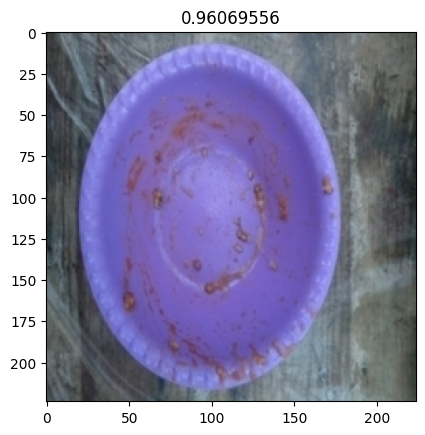

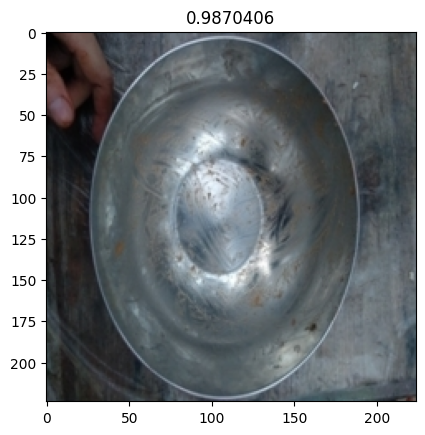

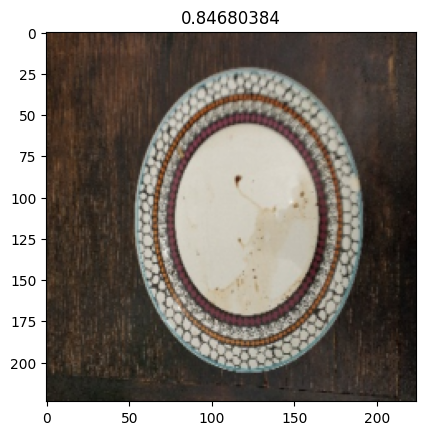

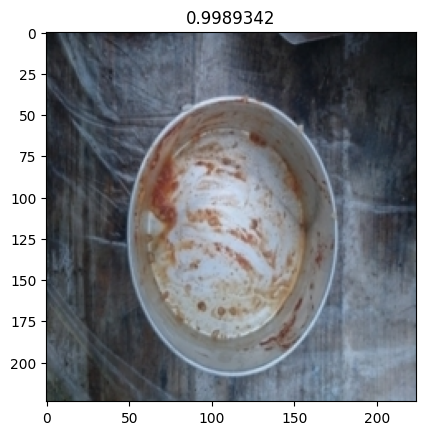

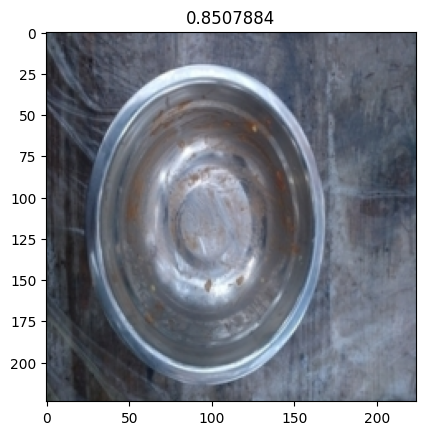

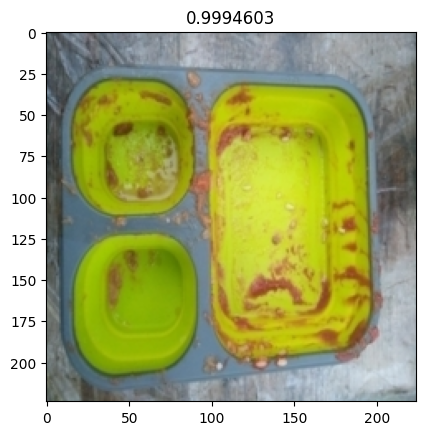

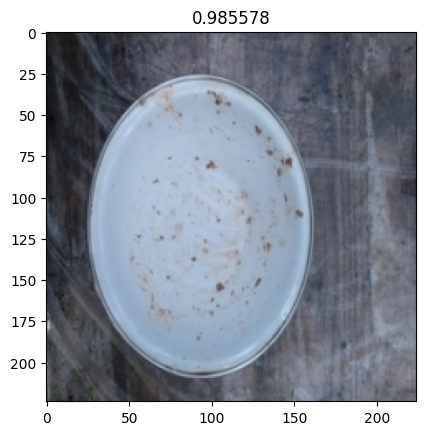

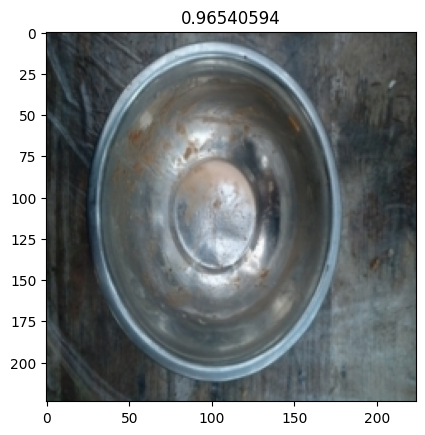

In [17]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [18]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [19]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [20]:
submission_df.to_csv('submission.csv')